In [1]:
#this noteboook was "heavily" inspired by https://elte.me/2021-03-10-keypoint-regression-fastai
from fastai.vision.all import *
import pdb

In [2]:
#use cuda if avaliable, otherwise use cpu --- Not recomended to use CPU it will take a looooong time
device = 'cuda' if torch.cuda.is_available else 'cpu'
defaults.device = torch.device(device)

In [3]:
#load data | file names and landmarks
neuro_list = pd.read_csv("../data/TorontoNeuroFace_cropped_Landmarks.csv", index_col = 0)

#this are the test subjects. Test subjects were randomly selected, you can adjust this to your linking
test_subjects = list(pd.read_csv("../data/test_subjects.txt", index_col=0).Test_Subjects.values)


#test data frame
neuro_list_test = neuro_list[neuro_list['subject_id'].isin(test_subjects)]
#train + val data frame
neuro_list_train_val = neuro_list[~neuro_list['subject_id'].isin(test_subjects)]

#spit train and validation sets and add a column to indicate the group. Val subjects were randomly selected, you can adjust this to your linking
val_subjects = list(pd.read_csv("../data/val_subjects.txt", index_col=0).Val_Subjects.values)
neuro_list_train = neuro_list_train_val[~neuro_list_train_val['subject_id'].isin(val_subjects)].reset_index(drop=True)
neuro_list_train['is_valid'] = 0
neuro_list_val = neuro_list_train_val[neuro_list_train_val['subject_id'].isin(val_subjects)].reset_index(drop=True)
neuro_list_val['is_valid'] = 1
#merge train and val groups 
df = pd.concat([neuro_list_train, neuro_list_val])

cols = list(neuro_list.columns[4:])

In [4]:
#helper function to show results
#adjust the show functions so that you can see the images + landmarks
@typedispatch
def show_batch(x:TensorImage, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    #pdb.set_trace()
    for i,ctx in enumerate(ctxs): 
        x[i].show(ctx=ctx)   
        _descale(y[-1][i],256).show(ctx=ctx)

def show_the_results(x, y, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, stats = None):
    ncols = 2
    n = min(len(x[0]), max_n)
    if ctxs is None: ctxs = get_grid(ncols * n, nrows=nrows, ncols=ncols, 
                                     figsize=figsize, title='Target/Prediction')

    points, _,_  = get_preds_fromhm(y.detach().cpu().numpy())
    pp = TensorPoint(points*4)
    #pdb.set_trace()
    if stats is None:
        stats = imagenet_stats
    for tctx,pctx,j in zip(ctxs[0::ncols], ctxs[1::ncols], range(n)):
        #
        img = x[0][j]
        img.show(ctx=tctx)
        _descale(x[1][1][j],256).cpu().show(ctx=tctx)
        img.show(ctx=pctx)
        pp[j].show(ctx=pctx)
        

In [5]:
#generate heatmaps 
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

#heatmaps to (x,y)
def heatmap2argmax(heatmap, scale=False):
    if len(heatmap.shape)<4:
        heatmap = heatmap.unsqueeze(0)

    N, C, H, W = heatmap.shape
    index = heatmap.view(N,C,1,-1).argmax(dim=-1)
    pts = torch.cat([index%W, index//W], dim=2)
    
    if scale:
        scale = tensor([W,H], device=heatmap.device)
        pts = _scale(pts, scale)
    
    return pts

#scale and descale helpers
def _scale(p, s): return 2 * (p / s) - 1
def _descale(p, s): return (0.5*(p+1.))*s 

class Heatmap(TensorImageBase): 
    "Heatmap tensor, we can use the type to modify how we display things"
    pass

class HeatmapPoint(TensorPoint):
    """
    A class that mimics TensorPoint, but wraps it so
    we'll be able to override `show` methods with
    a different type.
    """
    pass

class HeatmapTransform(Transform):
    """
    A batch transform that turns TensorPoint instances into Heatmap instances,
    and Heatmap instances into HeatmapPoint instances.
    
    Used as the last transform after all other transformations. 
    """
    # We want the heat map transformation to happen last, so give it a high order value
    order=999
    
    def __init__(self, heatmap_size, sigma=5, **kwargs):
        """
        heatmap_size: Size of the heatmap to be created
        sigma: Standard deviation of the Gaussian kernel
        """
        super().__init__(**kwargs)
        self.sigma = sigma
        self.size = heatmap_size
    
    def encodes(self, x:TensorPoint):
        # The shape of x is (batch x n_points x 2)
        num_imgs = x.shape[0]
        num_points = x.shape[1]
        maps = np.zeros((num_imgs, num_points, *self.size), dtype = float)
        #M = np.zeros((num_imgs, num_points, *self.size), dtype = float)
        for b in range(num_imgs):
            rows = x[b][:]
            mu_x = (0.5 * (rows[:,0] + 1.) * self.size[0]).int()
            mu_y = (0.5 * (rows[:,1] + 1.) * self.size[1]).int()
            for c in range(num_points):
                maps[b][c] = draw_umich_gaussian(maps[b][c], [mu_x[c], mu_y[c]], self.sigma)
                #M[b][c] = grey_dilation(maps[b][c], size=(3,3))
                #M[b][c] = np.where(M[b][c]>=0.5,1,0)  #in the paper it says 0.2 instead of 0.5

        return Heatmap(torch.tensor(maps)).to(x.device), x
    
    def decodes(self, x:Heatmap):
        """
        Decodes a heat map back into a set of points by finding
        the coordinates of their argmax.
        
        This returns a HeatmapPoint class rather than a TensorPoint
        class, so we can modify how we display the output.
        """
       
        # Flatten the points along the final axis,
        # and find the argmax per channel
        return HeatmapPoint(heatmap2argmax(x), source_heatmap=x)

In [6]:
#Generate a FastAI datablock that gets an image and landmarks and returns:
# - Image (normalized with Imagenet Stats)
# - Heatmaps
# - Mask
# - Ground Truth landmarks

# Some random transformations that are applied to the images include:
# - Random rotation (-10 to +10 deg)
# - Random zoom (-0.9 to 1.15)
# See FastAI for other transformations 

def get_x(x) : 
    return Path('../data/cropped')/x['file_name']

def get_y(x):
    
    val = x[cols].values
    points = torch.from_numpy(np.array(val, dtype=np.float)).view(-1,2)
    return points

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    splitter= ColSplitter('is_valid'),
    get_x = get_x,
    get_y = get_y,
    #item_tfms = Resize((400,400)),
    batch_tfms = [*aug_transforms(size=(256,256),do_flip=False, min_zoom = 0.9, max_zoom = 1.15, max_warp=0, pad_mode='zeros'), 
                  #Normalize.from_stats(*imagenet_stats),
                  #TensorNormalize(),
                  #HeatmapTransform(image_size=256),
                  HeatmapTransform(heatmap_size=(64,64))
                 ]
    )

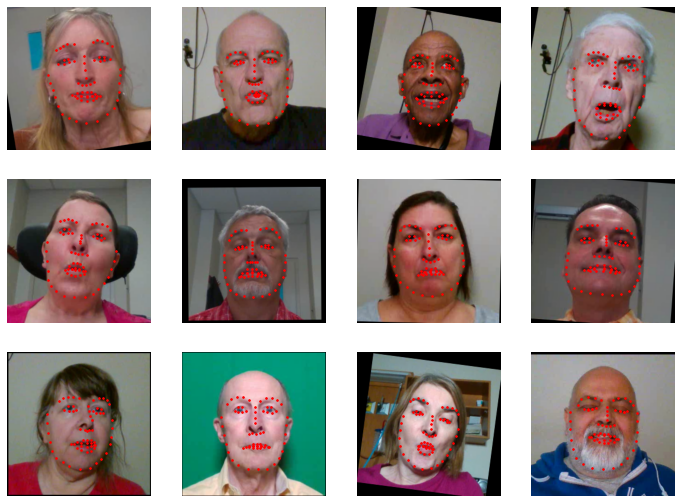

In [7]:
#show one batch of the training set
dls = dblock.dataloaders(df, num_workers=0, bs = 24)
dls.show_batch(max_n=12)

In [8]:
class WingLoss(nn.Module):
    """
    https://arxiv.org/pdf/1711.06753.pdf
    Refactored implementation from  https://github.com/BloodAxe/pytorch-toolbelt/.
    Supports intermediate supervision.
    """
    def __init__(self, width=5, curvature=0.5):
        super(WingLoss, self).__init__()
        self.w = width
        self.curvature = curvature
        self.c = self.w - self.w * math.log(1 + self.w / self.curvature)

    def __forward_single(self, preds, target):
        preds = TensorBase(preds) #convert tensorImage to tensor 
        target = TensorBase(target) #convert tensorImage to tensor 
        diff_abs = (target - preds).abs()
        loss = diff_abs.clone()

        idx_smaller = diff_abs < self.w
        idx_bigger = diff_abs >= self.w

        loss[idx_smaller] = self.w * torch.log(1 + diff_abs[idx_smaller] / self.curvature)
        loss[idx_bigger] = loss[idx_bigger] - self.c

        return loss.mean()

    def forward(self, preds, target):
        loss = 0
        
        preds = preds[1]

        if not isinstance(preds, tuple):
            preds = (preds,)

        for i in range(len(preds)):
            loss += self.__forward_single(preds[i], target)

        return loss
